# Классификация текстов

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Для выполнения заказа, нам необходимо решить задачу классификации.

# Содержание
- 1. [Подготовка данных](#title1)
- 2. [Разработка модели](#title2)
-    [Логистическая регрессия](#title3)
-    [LightGBM](#title4)
- 3. [Вывод](#title5)

In [16]:
import re

import lightgbm as lgb
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords as nltk_stopwords
from wordcloud import WordCloud
from pandarallel import pandarallel
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from tqdm import tqdm

STATE = np.random.RandomState(12345)

In [2]:
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
!python -m spacy download en_core_web_sm

## <a id="title1">1. Загрузим и подготовим данные для анализа</a>

In [4]:
df = pd.read_csv('/datasets/toxic_comments.csv', usecols=['text', 'toxic'])

In [5]:
df.shape

(159292, 2)

In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

Данные представляют собой набор твитов с маркировкой токсичности комментария

In [8]:
df['text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [9]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [10]:
text_low = df['text'].progress_apply(lambda x: re.sub(r'[^a-zA-Z\']', ' ',x.lower()))

100%|██████████| 159292/159292 [00:03<00:00, 47831.56it/s]


In [11]:
%%time
try:
    df['text_lemm'] = pd.read_csv('true_lemm.csv', usecols=[1])

except:
    nlp = spacy.load("en_core_web_sm")
    lemmed_finaly = []
    for doc in nlp.pipe(text_low, disable=['parser', 'ner'], n_process=-1):
        lemmed_finaly.append(' '.join([token.lemma_ for token in doc if not token.is_stop]))
    df['text_lemm'] = pd.Series(lemmed_finaly)

CPU times: total: 4min 7s
Wall time: 5min 34s


In [12]:
df.dropna(inplace=True)

In [13]:
df.head()

,text,toxic,text_lemm
0,Explanation\nWhy the edits made under my usern...,0,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,0,d'aww match background colour seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man try edit war guy constantly remove...
3,"""\nMore\nI can't make any real suggestions on ...",0,real suggestion improvement wonder secti...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


Тексты были отфильтрованы и выделены леммы слов

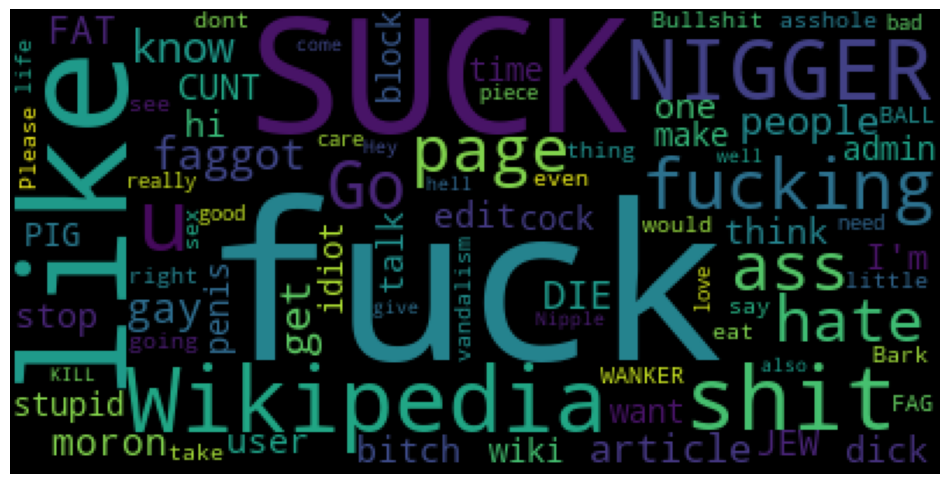

In [17]:
stopwords = nltk_stopwords.words('english')
df_negative = df[df['toxic'] == 1]
text_cloud = ' '.join(df_negative['text'])
cloud = WordCloud(stopwords=stopwords, max_words=80, collocations=False).generate(text_cloud)
plt.figure(figsize=(12,8))
plt.imshow(cloud)
plt.axis('off')
plt.show()

## <a id="title2">2. Обучим модели</a>

### 2.1 Подготовим обучающие и тестовые выборки

In [18]:
X = df['text_lemm']
y = df['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=STATE, stratify=y)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(111504,)
(47788,)
(111504,)
(47788,)


In [20]:
class_weight = {
    0: 1.0,
    1: 9.0,
}

### <a id="title3">2.2 Логистическая регрессия</a>

In [21]:
%%time
params={'model__C': [.1, 10],
        'model__class_weight': [class_weight],
        'model__random_state': [STATE],
        'model__verbose': [2],
        'model__n_jobs': [-1],
        'vect__ngram_range':[(1,2), (1,4)]
        }
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model',LogisticRegression())])
grid = GridSearchCV(pipe, cv=3, n_jobs=-1, param_grid=params ,scoring='f1')
grid.fit(X_train, y_train)
display(grid.best_params_)
display(grid.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   36.4s finished


{'model__C': 10,
 'model__class_weight': {0: 1.0, 1: 9.0},
 'model__n_jobs': -1,
 'model__random_state': RandomState(MT19937) at 0x27CF1A00440,
 'model__verbose': 2,
 'vect__ngram_range': (1, 2)}

0.7846585164023425

CPU times: total: 16.3 s
Wall time: 8min 43s


{'model__C': 10,
 'model__class_weight': {0: 1.0, 1: 9.0},
 'model__n_jobs': -1,
 'model__random_state': RandomState(MT19937) at 0x1B93D5D5C40,
 'model__verbose': 2,
 'vect__ngram_range': (1, 2)}

0.784232183883116

0.7887727924605615

In [22]:
pipe_best={'C':  10,
           'class_weight': 'class_weight',
           'random_state': STATE,
           'verbose': 2,
           'n_jobs': -1,
           'ngram_range': (1,2)
          }
best_f1 = 0.78

In [23]:
# Векторизируем подготовленные тексты

tf_idf = TfidfVectorizer(ngram_range=(1,2))

tf_idf.fit(X_train)
X_train = tf_idf.transform(X_train)


In [24]:
print(X_train.shape)

(111504, 1777379)


In [25]:
model = LogisticRegression(C=1, class_weight=class_weight, random_state=STATE, n_jobs=-1)
model.fit(X_train, y_train)
predictions = model.predict_proba(X_train)
best_threshold = 0
best_f1 = 0
for threshold in np.arange(0, 1, 0.02):
    prob = np.where(predictions[:, 1] >= threshold, 1, 0)
    f1 = f1_score(y_train, prob)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print(f'Лучшая f1: {best_f1:.2f}, Лучший порог: {best_threshold}')

Лучшая f1: 0.96, Лучший порог: 0.66


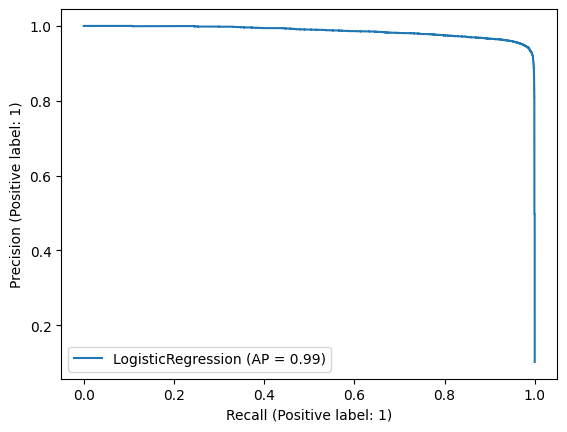

In [26]:
PrecisionRecallDisplay.from_estimator(model, X_train, y_train)

### <a id="title4">2.3 LightGBM</a>

С помощью кроссвалидации используя GridSearchCV подберем гиперпараметры модели

In [27]:
%%time

params = {
    'num_leaves': [31, 51],
    'class_weight': [class_weight],
    'metric': ['binary_logloss'],
    'verbose': [1],
    'n_estimators': [320, 640],
    'boosting_type': ['gbdt'],
    'random_state': [STATE],
    'n_jobs': [-1]
    }

model_l = lgb.LGBMClassifier()
grid = GridSearchCV(model_l, param_grid=params, cv=3, scoring='f1')
model_grid = grid.fit(X_train, y_train)
display(model_grid.best_params_)
gbm_f1 = model_grid.best_score_
print(f'Метрика F1 {gbm_f1:.3f}')

[LightGBM] [Info] Number of positive: 7553, number of negative: 66783
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.842381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 463416
[LightGBM] [Info] Number of data points in the train set: 74336, number of used features: 12901
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504430 -> initscore=0.017721
[LightGBM] [Info] Start training from score 0.017721
[LightGBM] [Info] Number of positive: 7553, number of negative: 66783
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.936054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461856
[LightGBM] [Info] Number of data points in the train set: 74336, number of used features: 12849
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504430 -> initscore=0.017721
[LightGBM] [Info] Start training from score 0.017721
[L

{'boosting_type': 'gbdt',
 'class_weight': {0: 1.0, 1: 9.0},
 'metric': 'binary_logloss',
 'n_estimators': 640,
 'n_jobs': -1,
 'num_leaves': 51,
 'random_state': RandomState(MT19937) at 0x27CF1A00440,
 'verbose': 1}

Метрика F1 0.766
CPU times: total: 3h 28min 57s
Wall time: 20min 32s


In [24]:
grid_best = {'boosting_type': 'gbdt',
             'class_weight': 'class_weight',
             'metric': 'binary_logloss',
             'n_estimators': 640,
             'num_leaves': 51,
             'verbose': 1}
grid_f1 = 0.77

После анализа результатов обучения моделей, лучшую итоговую метрику показала модель на основе LightGBM, выберем её для финального тестирования

### <a id="title4">2.4 Тест финальной модели</a>

In [28]:
X_test = tf_idf.transform(X_test)

In [29]:
model = lgb.LGBMClassifier(class_weight=class_weight, n_estimators=640, num_leaves=51, verbose=1)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 11330, number of negative: 100174
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.309215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673623
[LightGBM] [Info] Number of data points in the train set: 111504, number of used features: 18857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504442 -> initscore=0.017770
[LightGBM] [Info] Start training from score 0.017770


LGBMClassifier(class_weight={0: 1.0, 1: 9.0}, n_estimators=640, num_leaves=51,
               verbose=1)

In [30]:
predictions_test = model.predict(X_test)
print(f'Precision score: {precision_score(y_test, predictions_test):.2f}')
print(f'Recall score: {recall_score(y_test, predictions_test):.2f}')
print(f'f1 score: {f1_score(y_test, predictions_test):.2f}')

Precision score: 0.77
Recall score: 0.78
f1 score: 0.77


## <a id="title5">3. Выводы</a>

Мы выполнили исследование для интернет-магазина «Викишоп» для запуска нового сервиса. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен был инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Для выполнения заказа нами были протестированы разные ML-модели классификации комментариев на позитивные и негативные. В результате проделанной работы, была подготовлена ML-модель на основе бустинга LightGBM, которая показала итоговую метрику f1= 0.77, что полностью удовлетворяет поставленной задаче.